## Get Features

Neded to change to correct environment (problems with linkgrammar)

pip install pyenchant

pip install https://github.com/kpu/kenlm/archive/master.zip

and others...

In [5]:
!bash /home/mlynatom/grammaticality-metrics/heilman-et-al/test.sh /home/mlynatom/grammaticality-metrics/heilman-et-al/sentences.txt

Extracting features from /home/mlynatom/grammaticality-metrics/heilman-et-al/sentences.txt...
Loading the LM will be faster if you build a binary file.
Reading /home/mlynatom/grammaticality-metrics/native_giga.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Loading the LM will be faster if you build a binary file.
Reading /home/mlynatom/grammaticality-metrics/nonnative.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Loading features from /home/mlynatom/grammaticality-metrics/heilman-et-al/sentences.txt
0
Done. features saved to /home/mlynatom/grammaticality-metrics/regression/features/sentences.txt.json
Done


## Regression

In [119]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy import optimize
import numpy as np
from sklearn.linear_model import RidgeCV, Ridge, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score

from sklearn.model_selection import ParameterGrid
from sklearn.compose import ColumnTransformer
from scipy.stats import pearsonr, kendalltau

from tqdm import tqdm

In [79]:
data = pd.read_json("/home/mlynatom/grammaticality-metrics/heilman-et-al/features/gug_sentences.txt.json", lines=True)

In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   3129 non-null   object 
 1   parse_score          3129 non-null   float64
 2   sentential_top_node  3129 non-null   bool   
 3   dep_count            3129 non-null   int64  
 4   length               3129 non-null   int64  
 5   num_miss             3129 non-null   int64  
 6   prop_miss            3129 non-null   float64
 7   log_miss             3129 non-null   float64
 8   complete_link        3129 non-null   bool   
 9   min_s_1              3129 non-null   float64
 10  max_s_1              3129 non-null   float64
 11  sum_s_1              3129 non-null   float64
 12  min_s_2              3117 non-null   float64
 13  max_s_2              3117 non-null   float64
 14  sum_s_2              3117 non-null   float64
 15  min_s_3              3106 non-null   f

In [81]:
data.head()

id  parse_score  sentential_top_node  dep_count  length  \
0  gug_sentences.txt.0    -6.017418                 True          0      21   
1  gug_sentences.txt.1    -6.424152                 True          0      21   
2  gug_sentences.txt.2    -5.586782                 True          0      10   
3  gug_sentences.txt.3    -9.942500                 True          0       4   
4  gug_sentences.txt.4    -6.999736                 True          1      22   

   num_miss  prop_miss  log_miss  complete_link   min_s_1  ...   min_s_2  \
0         1       0.05  0.693147           True -4.198308  ... -8.126179   
1         2       0.10  1.098612           True -4.121595  ... -7.526754   
2         0       0.00  0.000000           True -4.269293  ... -7.664845   
3         0       0.00  0.000000           True -3.721482  ... -6.397513   
4         0       0.00  0.000000           True -4.242428  ... -9.033456   

    max_s_2   sum_s_2    min_s_3   max_s_3   sum_s_3  giga_oov    giga_p  \
0 -3.946653 -5.603347 -12.163334 -5.006789 -8.242196         2 -2.871818   
1 -3.737654 -5.590213 -11.925205 -5.921506 -7.897653         3 -2.701693   
2 -3.630444 -5.336554  -8.656352 -6.411362 -7.364122         1 -2.565764   
3 -5.235729 -5.828032  -8.804228 -8.780070 -8.792149         1 -4.631810   
4 -3.934530 -6.281970 -11.981050 -6.278505 -9.136310         1 -3.156215   

   toefl11_oov  toefl11_p  
0           20  -0.845929  
1           20  -0.769989  
2           10  -0.999493  
3            4  -2.039621  
4           22  -0.621265  

[5 rows x 22 columns]

In [82]:
gug_data = pd.read_csv("/home/mlynatom/grammaticality-metrics/heilman-et-al/gug-data/gug_annotations.tsv", sep="\t")

In [83]:
gug_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Id                       3129 non-null   int64  
 1   Sentence                 3129 non-null   object 
 2   Expert Judgement         3129 non-null   int64  
 3   Crowd Flower Judgements  3129 non-null   object 
 4   Average                  3129 non-null   float64
 5   Dataset                  3129 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 146.8+ KB


In [84]:
gug_data.head()

Id                                           Sentence  Expert Judgement  \
0   1  If the teacher once entered in to the class sh...                 3   
1   2  So I think we can not live if old people could...                 2   
2   3  New and new technology has been introduced to ...                 3   
3   4                                   For not use car.                 1   
4   5  Here was no promise of morning except that we ...                 3   

  Crowd Flower Judgements   Average Dataset  
0         [3, 3, 3, 4, 2]  3.000000   train  
1         [2, 2, 1, 2, 3]  2.000000    test  
2         [3, 4, 3, 3, 2]  3.000000     dev  
3         [3, 4, 3, 4, 3]  3.000000    test  
4         [2, 4, 3, 2, 3]  2.833333    test

In [85]:
merged_data = pd.concat([data, gug_data], axis=1, )
display(merged_data.head())

id  parse_score  sentential_top_node  dep_count  length  \
0  gug_sentences.txt.0    -6.017418                 True          0      21   
1  gug_sentences.txt.1    -6.424152                 True          0      21   
2  gug_sentences.txt.2    -5.586782                 True          0      10   
3  gug_sentences.txt.3    -9.942500                 True          0       4   
4  gug_sentences.txt.4    -6.999736                 True          1      22   

   num_miss  prop_miss  log_miss  complete_link   min_s_1  ...  giga_oov  \
0         1       0.05  0.693147           True -4.198308  ...         2   
1         2       0.10  1.098612           True -4.121595  ...         3   
2         0       0.00  0.000000           True -4.269293  ...         1   
3         0       0.00  0.000000           True -3.721482  ...         1   
4         0       0.00  0.000000           True -4.242428  ...         1   

     giga_p  toefl11_oov  toefl11_p  Id  \
0 -2.871818           20  -0.845929   1   
1 -2.701693           20  -0.769989   2   
2 -2.565764           10  -0.999493   3   
3 -4.631810            4  -2.039621   4   
4 -3.156215           22  -0.621265   5   

                                            Sentence  Expert Judgement  \
0  If the teacher once entered in to the class sh...                 3   
1  So I think we can not live if old people could...                 2   
2  New and new technology has been introduced to ...                 3   
3                                   For not use car.                 1   
4  Here was no promise of morning except that we ...                 3   

   Crowd Flower Judgements   Average  Dataset  
0          [3, 3, 3, 4, 2]  3.000000    train  
1          [2, 2, 1, 2, 3]  2.000000     test  
2          [3, 4, 3, 3, 2]  3.000000      dev  
3          [3, 4, 3, 4, 3]  3.000000     test  
4          [2, 4, 3, 2, 3]  2.833333     test  

[5 rows x 28 columns]

In [86]:
merged_data = merged_data[merged_data["Expert Judgement"] != 0] #not valid data

In [87]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3019 entries, 0 to 3128
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       3019 non-null   object 
 1   parse_score              3019 non-null   float64
 2   sentential_top_node      3019 non-null   bool   
 3   dep_count                3019 non-null   int64  
 4   length                   3019 non-null   int64  
 5   num_miss                 3019 non-null   int64  
 6   prop_miss                3019 non-null   float64
 7   log_miss                 3019 non-null   float64
 8   complete_link            3019 non-null   bool   
 9   min_s_1                  3019 non-null   float64
 10  max_s_1                  3019 non-null   float64
 11  sum_s_1                  3019 non-null   float64
 12  min_s_2                  3016 non-null   float64
 13  max_s_2                  3016 non-null   float64
 14  sum_s_2                  3016

In [16]:
train = merged_data[merged_data["Dataset"] == "train"]
val = merged_data[merged_data["Dataset"] == "dev"]
test = merged_data[merged_data["Dataset"] == "test"]

In [88]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(merged_data, test_size=0.2)
val, test = train_test_split(test, test_size=0.2)

In [89]:
train = train.drop(columns=["id", "Id", "Sentence", "Expert Judgement", "Crowd Flower Judgements", "Dataset"])
val = val.drop(columns=["id", "Id", "Sentence", "Expert Judgement", "Crowd Flower Judgements", "Dataset"])
test = test.drop(columns=["id", "Id", "Sentence", "Expert Judgement", "Crowd Flower Judgements", "Dataset"])

In [90]:
#drop rows with nans
train = train.dropna(axis=0)
val = val.dropna(axis=0)
test = test.dropna(axis=0)

In [91]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2411 entries, 708 to 2623
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   parse_score          2411 non-null   float64
 1   sentential_top_node  2411 non-null   bool   
 2   dep_count            2411 non-null   int64  
 3   length               2411 non-null   int64  
 4   num_miss             2411 non-null   int64  
 5   prop_miss            2411 non-null   float64
 6   log_miss             2411 non-null   float64
 7   complete_link        2411 non-null   bool   
 8   min_s_1              2411 non-null   float64
 9   max_s_1              2411 non-null   float64
 10  sum_s_1              2411 non-null   float64
 11  min_s_2              2411 non-null   float64
 12  max_s_2              2411 non-null   float64
 13  sum_s_2              2411 non-null   float64
 14  min_s_3              2411 non-null   float64
 15  max_s_3              2411 non-null   floa

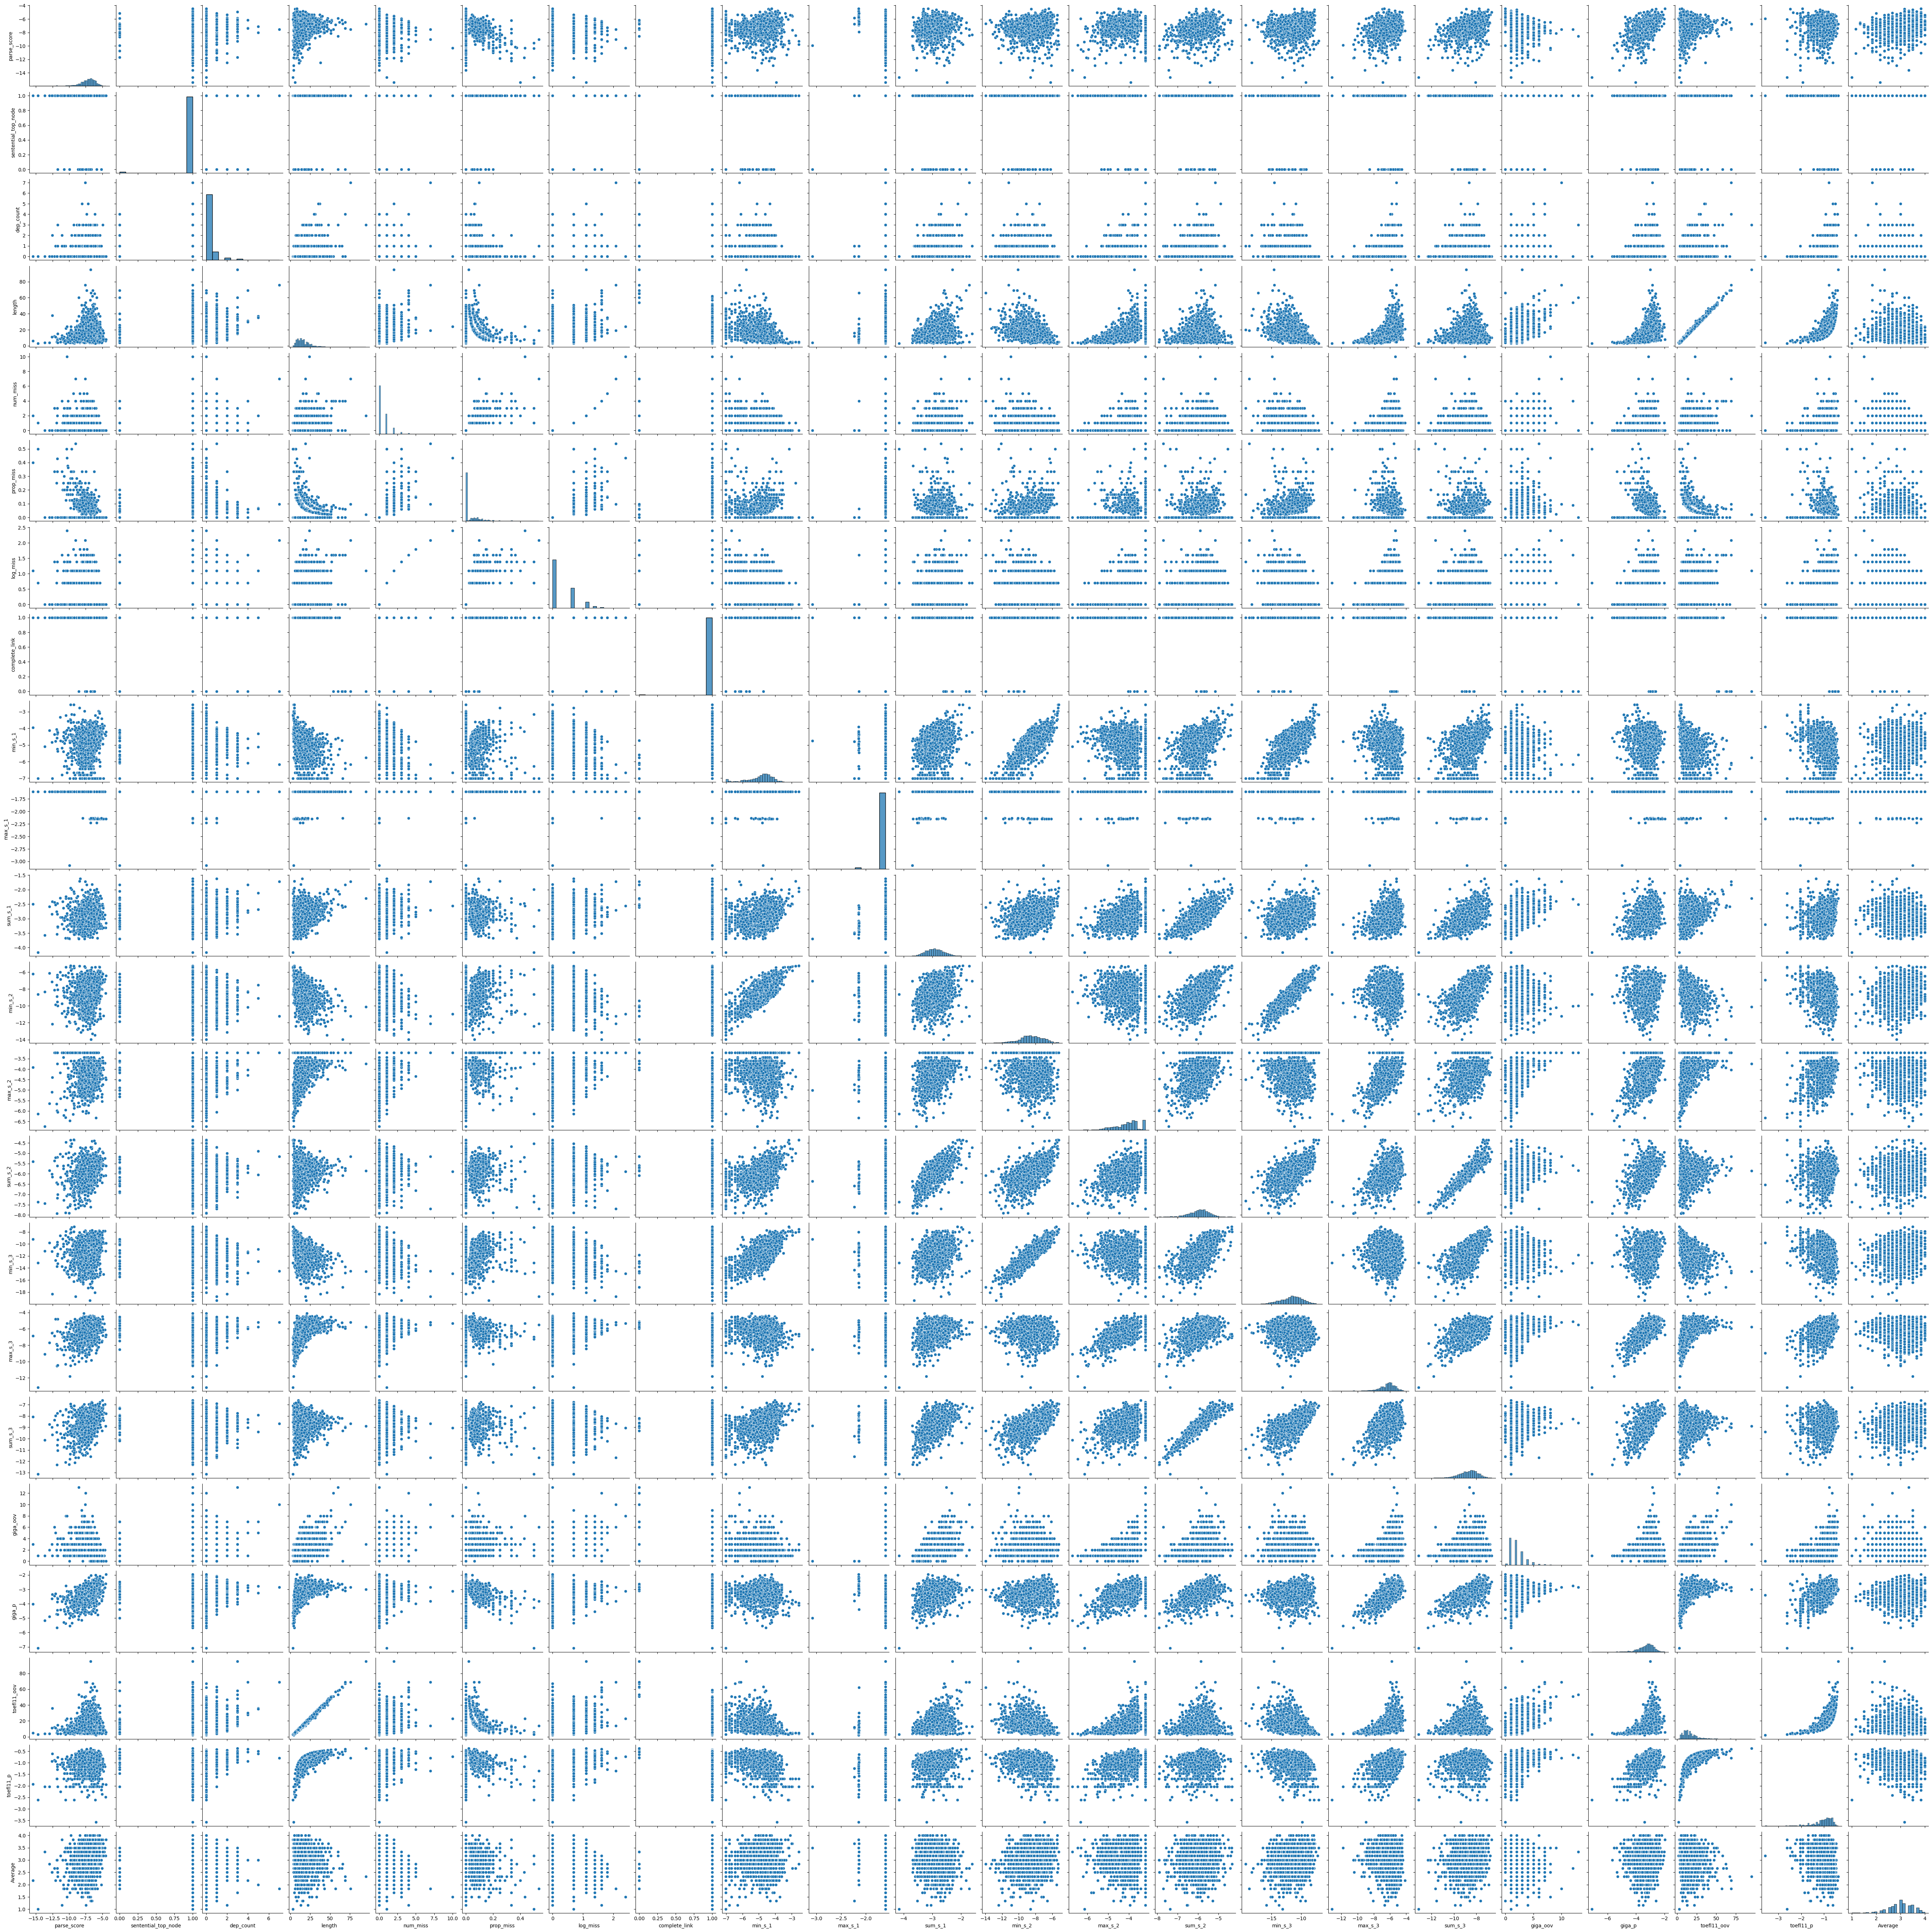

In [20]:
import seaborn as sns

sns.pairplot(train)

In [92]:
X_train = train.drop("Average", axis=1)
y_train = train["Average"]

X_val = val.drop("Average", axis=1)
y_val = val["Average"]

X_test = test.drop("Average", axis=1)
y_test = test["Average"]

In [120]:
def apply_scaling(train: pd.DataFrame, val: pd.DataFrame, test: pd.DataFrame, scaler):
    X_train_scaled = train
    X_val_scaled = val
    X_test_scaled = test
    if scaler is not None:
        #init scaler
        scaler = scaler()
        if isinstance(scaler, StandardScaler):
            #do not standardize binary values
            #init columntransformer
            ct = ColumnTransformer([("StandardScaler", scaler, X_train.select_dtypes(exclude="bool").columns)], remainder="passthrough")
            X_train_scaled = ct.fit_transform(train)
            X_val_scaled = ct.transform(val)
            X_test_scaled = ct.transform(test)
        else:
            #if MinMax scaler is called binary values are not affected
            X_train_scaled = scaler.fit_transform(train)
            X_val_scaled = scaler.transform(val)
            X_test_scaled = scaler.transform(test)

    return X_train_scaled, X_val_scaled, X_test_scaled

In [121]:
X_train_scaled, X_val_scaled, X_test_scaled = apply_scaling(X_train, X_val, X_test, StandardScaler)

In [123]:
def get_opt_ridge_model(Xtrain, Xval, ytrain, yval):
    def ridgemodel_eval(alpha):
        clf = Ridge(alpha=alpha)
        clf.fit(Xtrain, ytrain)
        return mean_squared_error(yval, clf.predict(Xval), squared = False)

    # Find Ridge alpha automatically
    opt_alpha = optimize.minimize_scalar(ridgemodel_eval, options = {'maxiter': 30}, method = 'bounded', bounds=(0.1, 400))
    print('Optimal alpha', opt_alpha)
    print("\n")

    clf_opt_ridge = Ridge(alpha = opt_alpha.x)
    clf_opt_ridge.fit(Xtrain, ytrain)
    return clf_opt_ridge

In [34]:
#opt_model = get_opt_ridge_model(X_train, X_val, y_train, y_val)

Optimal alpha  message: Solution found.
 success: True
  status: 0
     fun: 0.48434510589835356
       x: 7.213051790939711
     nit: 17
    nfev: 17




In [124]:
opt_model = get_opt_ridge_model(X_train_scaled, X_val_scaled, y_train, y_val)

Optimal alpha  message: Solution found.
 success: True
  status: 0
     fun: 0.43749946651511323
       x: 17.063537760101266
     nit: 19
    nfev: 19




In [125]:
preds = opt_model.predict(X_test_scaled)

In [126]:
pearsonr(preds, y_test)

PearsonRResult(statistic=0.4910648507222679, pvalue=1.0738005395016291e-08)

In [127]:
kendalltau(preds, y_test)

SignificanceResult(statistic=0.30086580086580084, pvalue=2.608153848621959e-06)

### binarize

In [128]:
def binarize(lst):
    return [1 if avg >= 3.5 else 0 for avg in lst]

In [129]:
bin_preds_ridge = binarize(preds)

In [130]:
preds

array([2.76262822, 3.38414587, 2.97250942, 3.11065002, 3.16170516,
       2.69003657, 2.87686059, 3.25705068, 3.27971872, 3.13021904,
       3.06245575, 3.23533204, 3.19751541, 3.15444747, 3.07747646,
       2.82807399, 3.16541958, 3.17276983, 2.93605391, 2.64064341,
       3.23180388, 2.99723709, 3.20245874, 2.73387284, 3.23273682,
       2.61342127, 3.09318453, 2.79327795, 2.96529143, 2.93413617,
       2.93326344, 3.1624654 , 3.25358462, 3.23753508, 3.18018445,
       2.83826329, 3.28336972, 2.7810003 , 3.14436384, 3.32504967,
       3.17336256, 3.08714173, 3.04278374, 3.17328232, 3.22745842,
       3.14677827, 3.11744958, 2.71671908, 2.88044382, 3.02599767,
       2.86243696, 3.1355939 , 3.25793069, 2.93700306, 3.14137155,
       3.18258593, 3.26349164, 2.63964593, 3.06833398, 3.00146574,
       2.69487934, 3.02674083, 3.31533455, 2.99284501, 2.99947778,
       3.05863134, 3.21090421, 3.34927662, 2.91294954, 2.97666119,
       3.06328222, 2.99273309, 3.11021112, 3.28748661, 3.24055

In [131]:
y_train_bin = binarize(y_train)
y_val_bin = binarize(y_val)
y_test_bin = binarize(y_test)

In [133]:
display(np.unique(y_train_bin, return_counts=True))
display(np.unique(y_val_bin, return_counts=True))

(array([0, 1]), array([1802,  609]))

(array([0, 1]), array([387,  95]))

In [134]:
np.unique(y_val, return_counts=True)

(array([1.        , 1.5       , 1.66666667, 1.83333333, 2.        ,
        2.16666667, 2.33333333, 2.5       , 2.66666667, 2.83333333,
        3.        , 3.16666667, 3.33333333, 3.5       , 3.66666667,
        3.83333333, 4.        ]),
 array([ 1,  3,  3,  5, 12, 11, 27, 32, 36, 55, 77, 75, 50, 42, 23, 21,  9]))

In [135]:
np.unique(bin_preds_ridge, return_counts=True)

(array([0]), array([121]))

In [136]:
accuracy_score(y_test_bin, bin_preds_ridge)

0.7024793388429752

In [137]:
kendalltau(y_test_bin, bin_preds_ridge)

SignificanceResult(statistic=nan, pvalue=nan)

## LOGREG

In [138]:
parameters_grid = ParameterGrid({"l1_ratio": list(np.arange(0, 1, 0.01))})

In [139]:
acc = []

for params in tqdm(parameters_grid):
    tmp_logreg = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=1000, **params)
    tmp_logreg.fit(X_train_scaled, y_train_bin)
    preds = tmp_logreg.predict(X_val_scaled)
    acc.append(accuracy_score(y_val_bin, preds))

  0%|          | 0/100 [00:00<?, ?it/s]/home/mlynatom/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  1%|          | 1/100 [00:00<00:34,  2.90it/s]/home/mlynatom/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  2%|▏         | 2/100 [00:00<00:38,  2.54it/s]/home/mlynatom/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  3%|▎         | 3/100 [00:01<00:39,  2.45it/s]/home/mlynatom/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  4%|▍         | 4/100 [00:02<00:49,  1.93it/s]


KeyboardInterrupt: 

In [89]:
best_l1 = parameters_grid[np.argmax(acc)]["l1_ratio"]

In [90]:
best_l1

0.39

In [41]:
logreg = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=10000, l1_ratio=best_l1)
logreg_clf = logreg.fit(X_train, y_train_bin)

In [140]:
logreg = LogisticRegression(penalty='l2', solver='saga', max_iter=10000)
logreg_clf = logreg.fit(X_train, y_train_bin)

In [143]:
preds_logreg = logreg_clf.predict(X_test)
display(preds_logreg)

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [144]:
np.unique(preds_logreg, return_counts=True)

(array([0, 1]), array([117,   4]))

In [145]:
accuracy_score(y_test_bin, preds_logreg)

0.71900826446281

In [146]:
kendalltau(y_test_bin, preds_logreg)

SignificanceResult(statistic=0.18300395476884015, pvalue=0.04499428531168309)

In [147]:
logreg_proba = logreg_clf.predict_proba(X_test)[:, 1]

In [148]:
pearsonr(logreg_proba, y_test)

PearsonRResult(statistic=0.44339215629652107, pvalue=3.518890382601341e-07)

In [149]:
kendalltau(logreg_proba, y_test)

SignificanceResult(statistic=0.3063492063492063, pvalue=1.708703395678783e-06)